In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

sources:

- Livre : 
    - Hands-on machine learning with scikit-learn, Keras & tensorflow (from Aurélien Géron)
    
    
- Evaluation des modèles:
    - https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation.

In [3]:
data = pd.read_csv('/Users/lucas/Desktop/Polytech/IG4/S7/projet_DS/mail_pre_process.csv')
print(data.shape)

(100000, 105)


<br>
<b> Chose à faire</b>:

- Avec valeurs numériques(voir si on peut ajouter les valeurs non-numériques):
    - Quelques graphes.. puis matrice de corrélation.
    - ACP.
    - Clustering(essayer plusieurs).
    - DeepLearning.

<br>
Pour prendre en compte les variables non-numériques, on doit utiliser la "Category Utility" (CU).
La CU d'un cluster d'un dataset est une valeur numérique qui reflète comment le clustering est bon:

- De grandes valeurs de CU indique un meilleur clustering.



<br>
<b>Petites analyses:</b>

In [4]:
data.columns

Index(['Unnamed: 0', 'DayWeek', 'Cat_1_level_1', 'Cat_1_level_2',
       'Cat_1_weight', 'Cat_2_level_1', 'Cat_2_level_2', 'Cat_2_weight',
       'Cat_3_level_1', 'Cat_3_level_2',
       ...
       'sent', 'shanna', 'thanks', 'tim', 'timothy', 'trading', 'type', 'upon',
       'week', 'would'],
      dtype='object', length=105)

In [ ]:
cmap = 'RdYlGn'
sns.heatmap(data.corr(),vmax=.3, center=0, cmap=cmap,square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

fig=plt.gcf()
fig.set_size_inches(10,8)

plt.show()

<br>
<b>ACP</b>

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [14]:
data_num = data.drop(columns=['DayWeek'])

In [7]:
scaler = StandardScaler()
num_scale = scaler.fit_transform(data_num)


In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score
X_train, X_test, y_train, y_test = train_test_split( data_num, data['DayWeek'], test_size=0.33, random_state=42)
clf = DecisionTreeClassifier()
#clf.fit(X_train, y_train)

accuracy = cross_val_score(clf, data_num, data['DayWeek'], cv=10)
print(np.mean(accuracy))


0.8001399999999999


In [15]:
pca = PCA(n_components=2)

coords = pca.fit_transform(num_scale)

In [16]:
print(sum(pca.explained_variance_ratio_))

0.5656988802749341


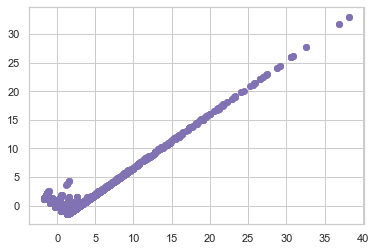

In [12]:


plt.scatter(coords[:, 0], coords[:, 1], c='m')


<br>
<b>Clustering</b>

In [14]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn import metrics

- K-means

Le coefficient de silhouette est l'un des meilleurs indicateurs pour choisir le nombre de cluster. Le coefficient de silhouette varie de -1 à 1:

- Un coefficient pour une instance <b>proche de 1</b> veut dire que cette instance est bien au sein de son cluster et loin des autres cluster.
- Un coefficient <b>proche de 0</b> veut dire que l'instance est proche de la limite du cluster.
- Un coefficient <b>proche de -1</b> veut dire que l'instance a peut être était assigné au mauvais cluster.


In [47]:
def best_k_means(i,n, data):
    #i min cluster we want to test
    #n max cluster we want to test
    #data is data on we want to test k.
    silhouette_scores = []
    for k in range(i,n+1):
        kmeans = KMeans(n_clusters= k, init='k-means++',n_init=100, random_state=111)
        y_pred = kmeans.fit_predict(data)
        sil_score = metrics.silhouette_score(data,kmeans.labels_)
        silhouette_scores.append(sil_score)
        
    return silhouette_scores

In [48]:
silhouette_score = best_k_means(2, 9, num_array)

[0.9683310056319818, 0.9324431003310856, 0.8388871986927537, 0.8010507128839138, 0.7617403731495331, 0.7345462002909028, 0.7111958574296707, 0.658975200628645]


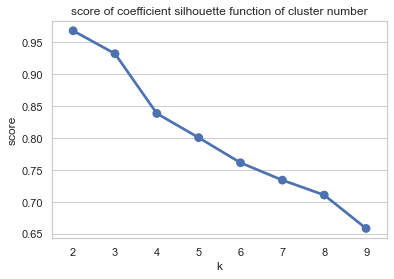

In [54]:
silhouette = pd.DataFrame(data={'k':range(2,10), 'score':silhouette_score})
print(silhouette_score)
ax = sns.pointplot(x='k', y='score', data=silhouette)
plt.title('score of coefficient silhouette function of cluster number')
plt.show()

Le nombre de cluster optimal entre 2 et 9 semble être 2.
Voyons à quoi ressemble le graphe des k-means avec 2 clusters.

In [104]:
kmeans = KMeans(n_clusters= 2, init='k-means++',n_init=100, random_state=111)
y_pred = kmeans.fit_predict(num_scale)
centroids = kmeans.cluster_centers_

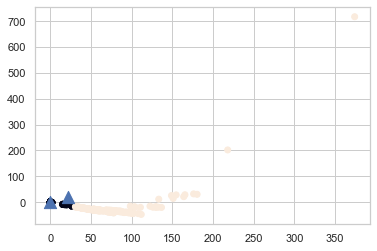

In [105]:
plt.scatter(coords[:, 0], coords[:, 1], c=kmeans.labels_)

plt.scatter(centroids[:,0], centroids[:,2], marker='^', s=150, c='b')

La limite entre les clusters reste flou.

- DBSCAN

Cet algorithme défini les clusters comme des régions continues de grandes densités.

Le coefficient de silhouette est généralement plus élevé pour les clusters convexes que pour les autres concepts de clusters, tels que les clusters basés sur la densité comme ceux obtenus via DBSCAN.

In [ ]:
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan.fit(num_scale)
y_pred = dbscan.fit_predict(num_scale)

In [ ]:
print(np.unique(dbscan.labels_)) #-1 for anomalies
print('-'*100)
print(len(dbscan.core_sample_indices_))

core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(num_scale, labels))




Le coefficient de silhouette étant <b>négatif</b>, le modèle ne semble pas approprié dans notres cas.

In [ ]:
plt.scatter( coords[:,0], coords[:,1], c=dbscan.labels_, cmap='Paired')
plt.title("DBSCAN")

<br>

- Gaussian Mixture Model.

Le GMM est un modèle probabiliste qui considère que les instances sont générées à partir d'un mix de plusieurs distribution Gaussienne dont les paramètres sont inconnus. 

In [68]:
def best_gmm(i,n, data):
    #i min cluster we want to test
    #n max cluster we want to test
    #data is data on we want to test k.
    bic = []
    aic = []
    for k in range(i,n+1):
        gm = GaussianMixture(n_components=k, n_init=10)
        gm.fit(data)
        y_pred = gm.predict(data)
        bic.append(gm.bic(data))
        aic.append(gm.aic(data))
        
    return bic, aic

In [93]:
#bic, aic = best_gmm(2,8, num_scale)

In [106]:
gm = GaussianMixture(n_components=3, n_init=10)
gm.fit(num_scale)

GaussianMixture(n_components=3, n_init=10)

In [66]:
print('convergence: ', gm.converged_)
print('iterations: ',gm.n_iter_)
print('BIC: ', gm.bic(num_scale))
print('AIC: ', gm.aic(num_scale))

convergence:  True
iterations:  18
BIC:  -12168080.076944215
AIC:  -12241015.676484141


In [ ]:
y_pred = gm.predict(num_scale)
np.unique(y_pred)

In [ ]:
plt.scatter( coords[:,0], coords[:,1], c=y_pred, cmap='Paired')